# Information Retrieval and Web Analytics

# Part 2: Indexing and evaluation


In [1]:
# mount google drive if using google collab, else skip
# we are not using it because it is more comfortable to use jupyter lab

BASEDIR = '.'

try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASEDIR = 'drive/MyDrive'
    
except ModuleNotFoundError:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# required imports for the notebook

import json
import csv
import math
import numpy as np
from array import array
from collections import defaultdict, Counter
import functools
from sklearn.manifold import TSNE


from nltk.stem import PorterStemmer

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import pandas as pd
import rank_bm25

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import time

RED = "\033[91m"
WHITE = "\033[0m"


def benchmark(func):
    """
    Decorador que te mide el tiempo que tarda la funcion en ejecutarse.
    Se puede usar como cualquier funcion, e.g. benchmark(func),
    pero al ser un decorador la gracia que tiene es que al hacer
    @benchmark
    def func():...
    cada vez que uses func() estaras usando benchmark(func)()
    :param func: la funcion que quieres testear
    :return: la funcion original envuelta por el codigo de testeo
    """
    def inner(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f'Time taken for {RED}{func.__name__}{WHITE}: {end - start:.4f}')
        return result

    return inner

In [4]:
# open results from last practice
tweets = pd.read_csv(f'{BASEDIR}/data/processed_tweets.csv')
tweets = tweets.reset_index()  # make sure indexes pair with number of rows

### Inverted index

In [5]:
# reuse of the function shown in class to transform text into lowercase and erase stop words in queries
def build_terms(line):
    """
    Preprocess the line removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    line = line.lower()
    
    # tremendo pero aligual rompe algo despues
    line = remove_punctuation(line)
    
    line = line.split()  # Tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  # eliminate the stopwords
    line = [stemmer.stem(word) for word in line] # perform stemming (HINT: use List Comprehension)
    return line


@benchmark
def create_index(tweets):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of Wikipedia articles
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    title_index = {}  # dictionary to map page titles to page ids

    for tweet in tweets.itertuples(index=True):  # Remember, lines contain all documents from file
        tweet_text = tweet.full_text
        
        # tweet id
        tweet_id = int(tweet.id.split("_")[1])

        terms = str(tweet_text).split(" ")  # page_title + page_text

        title_index[tweet_id] = tweet.user  ## we do not need to apply get terms to title because it used only to print titles and not in the index
        
        ## ===============================================================        
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is "web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [tweet_id, array('I', [position])]  #'I' indicates unsigned int (int in Python)

        # merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
    return index, title_index


In [6]:
index, title_index= create_index(tweets)

Time taken for create_index: 0.1754


### 5 Text queries

In [7]:
# def query(text)?:
# build terms(query)

# index = tremendo index
# foreach term in query
# index = index[term in entry] <- boolean mask, conjunctive AND

# return index <- the doc ids
# or
# return tweets[original_text][index] <- get original text of tweets containing all elements in query

def query(text, tweet_index=""):
    """
    search for a given text in the tweet collection using the
    inverted index we previously computed
    :param text: the query text
    :param tweet_index: inverted index of the collection, named as such because context of practice
    :return: list of tweet ids containing all (treated) terms in the query
    """
    
    # necessary step since same treatment applied to tweets
    terms = build_terms(text)
    
    # select tweet index, defaults to global index but can be specified
    tweet_index = tweet_index if tweet_index else index
    
    plausible_ids = []
    for query_term in terms:
        # tweet_index[query_term] is list of tweet ids containing query term + position(s) in text, could be useful in the future
        # plausible_ids[query_term] = tweet_index[query_term]
        
        # using sets is convenient for using reduce
        plausible_ids.append(set(term_pos[0] for term_pos in tweet_index[query_term]))
        
    # reduce list of sets to intersection of all
    relevant_ids = functools.reduce(lambda a, b: a.intersection(b), plausible_ids) if plausible_ids else []
                             
    return relevant_ids
        

In [8]:
query("")

[]

### Ranking results

In [9]:
# rank(query):
# query = build_terms(query)

# scores = {}
# length = {}
# foreach term in query:
# w_q = TF-IDF(term, query), docids = query(term)
# foreach docid in docids:
# scores[docid] += TF-IDF(term, tweets.full_text[docid]) * w_q
# ::
# foreach docid:
# scores[d] /= len(tweets.full_text[docid])

# sort scores, return top K


# relevant documents = query(query)
# foreach document in relevant_documents
# TF-IDF(document, query)



# TF-IDF(document, query):

# len(query(term)) is df(term) if term is one word 


def tf_idf(term_freq, document_freq, collection_len):
    if term_freq == 0 or document_freq == 0:
        return 0
    return (1 + math.log(term_freq)) * math.log(collection_len/document_freq)


def doc_score(doc_id, collection_index=index, collection=""):
    """
    vector de scores para el documento dado, es lo que hay que usar para
    la document length
    
    tremendo usarlo como {doc_id: doc_score(doc_id)} para todos los ids
    :param doc_id: document id que mirar
    :params: se supone que así será más flexible pero los defaults van finos asi que na
    :return: diccionario de terms y pesos, util para normalizar documentos
    """
    result={}
    
    collection = collection if collection else {tweet.id: tweet.full_text for tweet in tweets.itertuples(index=True)}
    collection_len = len(collection)
    
    document = str(collection[doc_id]).split(" ")
    term_frequencies = Counter(document)
    
    for term in document:
        document_freq = len(query(term, tweet_index=collection_index))
        result[term] = tf_idf(term_frequencies[term], document_freq, collection_len)
    return result


@benchmark
def collection_vectors(collection="", collection_index=index):
    """
    multi diccionario de documentos, terms y sus valores tf-idf
    """
    document_vectors = {}
    
    collection = collection if collection else {tweet.id: tweet.full_text for tweet in tweets.itertuples(index=True)}
    for doc_id, document in collection.items():
        document_vectors[doc_id] = doc_score(doc_id, collection_index=collection_index, collection=collection)
        
    return document_vectors


In [10]:
document_lengths = collection_vectors()

Time taken for collection_vectors: 22.9872


In [11]:
def cosine_score(query_text, collection_index=index, collection="", lengths=document_lengths, k=10):
    """
    computes cosine score of all documents in a collection against a query and ranks them
    accordingly
    """

    collection = collection if collection else {tweet.id: tweet.full_text for tweet in tweets.itertuples(index=True)}
    collection_len = len(collection)
           
    scores = {doc_id: 0 for doc_id in collection.keys()}
    
    # esto seguramente este mal
    # length = {doc_id: len(str(document).split(" ")) for doc_id, document in collection.items()}
    
    query_terms = build_terms(query_text) # necessary step since same treatment applied to tweets
    
    # dictionary of frequency of each term in the query
    query_frequencies = Counter(query_terms)
    
    for term in query_terms:
        # query of a term returns the set of documents containing the term
        document_freq = len(query(term, tweet_index=collection_index))
        
        query_weight = tf_idf(query_frequencies[term], document_freq, collection_len)
        
        """
        for term in query_terms:
        
        # query of a term returns the set of documents containing the term
        document_freq = len(query(term, tweet_index=collection_index))
        
        query_weight = tf_idf(query_frequencies[term], document_freq, collection_len)
        
        # hasta aqui esta bien probablemente, despues pasa algo raro
        for doc_id, document in collection.items():
            # counter of distinct terms in document
            term_frequencies = Counter(str(document).split(" "))
            document_weight = tf_idf(term_frequencies[term], document_freq, collection_len)
            scores[doc_id] += query_weight * document_weight
        """
            
        for doc_id, document in collection.items():

            term_frequencies = Counter(str(document).split(" "))
            document_weight = tf_idf(term_frequencies[term], document_freq, collection_len)

            doc_vec = list(lengths[doc_id].values())
            scores[doc_id] = query_weight * document_weight
            
    scores = {doc_id: score/np.linalg.norm(list(lengths[doc_id].values())) for doc_id, score in scores.items()}
        
    doc_ids_sorted = sorted(scores, key=scores.get, reverse=True)[:k]
    return {doc_id: scores[doc_id] for doc_id in doc_ids_sorted}

In [12]:
cosine_score("keep us posted")

{'doc_1546': 2.3995671065397546,
 'doc_1069': 2.248496421335798,
 'doc_1873': 1.9930095562822965,
 'doc_2330': 1.642266340337091,
 'doc_866': 1.4450083632022115,
 'doc_2640': 1.3283712106499805,
 'doc_1390': 1.2418825485022358,
 'doc_91': 1.1303636373681631,
 'doc_3870': 1.0782249055799842,
 'doc_3923': 1.069995714837875}

In [13]:
tweets[tweets['id'] == 'doc_3870']['full_text']

3869    sorri post much storm. hope understand. here’ ...
Name: full_text, dtype: object

### Evaluation

In [14]:
# useful functions for the evaluation
def precision_k (y_true, y_score, k=10, val_order='up'):
    val = 1 if val_order == "up" else -1
    order = y_score.argsort()[::val]
    y_true = y_true.take(order)
    relevant = np.sum(y_true[:k])
    return float(relevant/k)

def recall_k (y_true, y_score, k=10, val_order='up'):
    val = 1 if val_order == "up" else -1
    order = y_score.argsort()[::val]
    y_true = y_true.take(order)
    relevant = np.sum(y_true[:k])
    total_relevant = np.sum(y_true[:])
    return float(relevant/total_relevant)

def f1_score(precision, recall):
    return (2*precision*recall)/(precision+recall)

def avg_precision_at_k(doc_score, y_score, k=10, val_order='up'):
    val = 1 if val_order == "up" else -1
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::val]
    doc_score = np.take(doc_score, order[:k])
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

def map_at_k(search_res, k=10):
    avp = []
    for q in search_res["query_id"].unique():
        curr_data = search_res[search_res["query_id"] == q]
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["doc"]), k))
    return np.sum(avp) / len(avp)

def rr_at_k(doc_score, y_score, k=10, val_order='up'):
    val = 1 if val_order == "up" else -1
    order = np.argsort(y_score)[::val]
    doc_score = np.take(doc_score, order[:k])
    if np.sum(doc_score) == 0:
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)

def dcg_at_k(doc_score, y_score, k=10, val_order='up'):
    val = -1 if val_order == "up" else 1
    order = np.argsort(y_score)[::val]
    doc_score = np.take(doc_score, order[:k])
    gain = 2 ** doc_score - 1
    discounts = np.log2(np.arange(len(doc_score)) + 2)
    return np.sum(gain / discounts)


def ndcg_at_k(doc_score, y_score, k=10, val_order='up'):
    dcg_max = dcg_at_k(doc_score, doc_score, k, val_order=val_order)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

#### Baseline


In [15]:
# read the new csv file as a dataframe
with open(f'{BASEDIR}/data/evaluation_gt.csv', 'r') as file:
    ev_array = file.readlines()
    ev_array = [row.rstrip().split(',') for row in ev_array]
df_evaluation = pd.DataFrame(ev_array[1:], 
             columns=ev_array[0])
for index, row in df_evaluation.iterrows():
  df_evaluation['doc'][index] = int(df_evaluation['doc'][index].split("_")[1])
df_evaluation['query_id'] = pd.to_numeric(df_evaluation['query_id'])
df_evaluation['label'] = pd.to_numeric(df_evaluation['label'])
#df = df.set_index('doc').sort_index()

In [16]:
for q in [1,2,3]:
  current_query_res = df_evaluation[df_evaluation["query_id"] == q]
  k = 10
  precision = precision_k(current_query_res["label"], current_query_res["doc"], k, val_order='up')
  recall = recall_k(current_query_res["label"], current_query_res["doc"], k, val_order='up')
  print("Query {}".format(q))
  print("==> Precision@{}: {}\n".format(k, precision))
  print("==> Recall@{}: {}\n".format(k, recall))
  print("==> F1score@{}: {}\n".format(k, f1_score(precision, recall)))
  print("==> AveragePrecision@{}: {}\n".format(k, avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["doc"]), k, val_order='up')))
  print("==> MAP@{}: {}\n".format(k, map_at_k(df_evaluation, k)))
  print("==> RR@{}: {}\n".format(k, rr_at_k(np.array(current_query_res["label"]), np.array(current_query_res["doc"]), k, val_order='up')))
  print("==> NDCG@{}: {}\n".format(k, ndcg_at_k(np.array(current_query_res["label"]), np.array(current_query_res["doc"]), k, val_order='up')))


Query 1
==> Precision@10: 0.9

==> Recall@10: 0.9

==> F1score@10: 0.9

==> AveragePrecision@10: 0.89

==> MAP@10: 0.777420634920635

==> RR@10: 1.0

==> NDCG@10: 0.0734

Query 2
==> Precision@10: 0.8

==> Recall@10: 0.8

==> F1score@10: 0.8000000000000002

==> AveragePrecision@10: 0.5758730158730159

==> MAP@10: 0.777420634920635

==> RR@10: 0.5

==> NDCG@10: 0.1396

Query 3
==> Precision@10: 0.9

==> Recall@10: 0.9

==> F1score@10: 0.9

==> AveragePrecision@10: 0.866388888888889

==> MAP@10: 0.777420634920635

==> RR@10: 1.0

==> NDCG@10: 0.0663



#### Defined queries


In [17]:
# read the new csv file as a dataframe
with open(f'{BASEDIR}/data/evaluation_tweets.csv', 'r') as file:
    ev_array = file.readlines()
    ev_array = [row.rstrip().split(',') for row in ev_array]
df_queries = pd.DataFrame(ev_array[1:], 
             columns=ev_array[0])
for index, row in df_queries.iterrows():
    df_queries['doc'][index] = int(df_queries['doc'][index].split("_")[1])
df_queries['query_id'] = pd.to_numeric(df_queries['query_id'])
df_queries['label'] = pd.to_numeric(df_queries['label'])

queries = ["keep us posted", "ian update","disney world", "climate change", "hit state"]

for i in range(5):
    for j in range(1,4001):
        if ((df_queries['query_id'] == i+1) & (df_queries['doc'] == j)).any() == False:
            new_row = {'doc': j, 'query_id': i+1, 'label': 0, 'predicted': 0.0}
            df_queries = df_queries.append(new_row, ignore_index=True)

In [18]:
# add predicted values
df_queries['predicted'] = pd.to_numeric(df_queries['predicted'])
for i in range(5):
  cosine = cosine_score(queries[i], k=50)
  a = [int(key.split("_")[1]) for key in cosine.keys()]
  for val in a:
    index = df_queries.index[(df_queries['doc'] == val) & (df_queries['query_id'] == i+1)].to_list()
    df_queries['predicted'][index[0]] = cosine['doc_'+str(val)]
df_queries = df_queries.fillna({'predicted': 0.0})
df_queries['label'] = df_queries['predicted'].apply(lambda y: 1 if y >= 1.2 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
for q in [1,2,3,4,5]:
  current_query_res = df_queries[df_queries["query_id"] == q]
  k = 10
  precision = precision_k(current_query_res["label"], current_query_res["predicted"], k, val_order='down')
  recall = recall_k(current_query_res["label"], current_query_res["predicted"], k, val_order='down')
  print("Query {}".format(q))
  print("==> Precision@{}: {}\n".format(k, precision))
  print("==> Recall@{}: {}\n".format(k, recall))
  print("==> F1score@{}: {}\n".format(k, f1_score(precision, recall)))
  print("==> AveragePrecision@{}: {}\n".format(k, avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted"]), k, val_order='down')))
  print("==> MAP@{}: {}\n".format(k, map_at_k(df_queries, k)))
  print("==> RR@{}: {}\n".format(k, rr_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted"]), k, val_order='down')))
  print("==> NDCG@{}: {}\n".format(k, ndcg_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted"]), k, val_order='down')))


Query 1
==> Precision@10: 0.7

==> Recall@10: 1.0

==> F1score@10: 0.8235294117647058

==> AveragePrecision@10: 1.0

==> MAP@10: 0.0

==> RR@10: 1.0

==> NDCG@10: 0

Query 2
==> Precision@10: 0.7

==> Recall@10: 1.0

==> F1score@10: 0.8235294117647058

==> AveragePrecision@10: 1.0

==> MAP@10: 0.0

==> RR@10: 1.0

==> NDCG@10: 0

Query 3
==> Precision@10: 0.7

==> Recall@10: 1.0

==> F1score@10: 0.8235294117647058

==> AveragePrecision@10: 1.0

==> MAP@10: 0.0

==> RR@10: 1.0

==> NDCG@10: 0

Query 4
==> Precision@10: 0.8

==> Recall@10: 1.0

==> F1score@10: 0.888888888888889

==> AveragePrecision@10: 1.0

==> MAP@10: 0.0

==> RR@10: 1.0

==> NDCG@10: 0

Query 5
==> Precision@10: 0.4

==> Recall@10: 1.0

==> F1score@10: 0.5714285714285715

==> AveragePrecision@10: 1.0

==> MAP@10: 0.0

==> RR@10: 1.0

==> NDCG@10: 0



### Tweet representation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


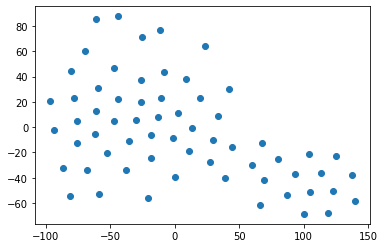

In [20]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

clean_tweets = []
for tweet in tweets.itertuples(index=True): 
        clean_tweets.append(str(tweet.full_text))
model = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)

X = model.wv[model.wv.key_to_index]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()